In [1]:
import chess
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
board = chess.Board()

In [3]:
board.turn

True

In [4]:
board.turn == chess.WHITE

True

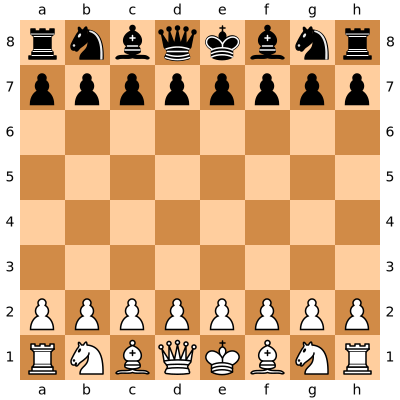

In [5]:
board

In [6]:
print(str(board))

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [7]:
chess.C1

2

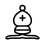

In [38]:
board.piece_at(chess.C1)

In [8]:
str(board.piece_at(chess.C1))

'B'

In [9]:
list(board.legal_moves)

[Move.from_uci('g1h3'),
 Move.from_uci('g1f3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('e2e3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('f2f4'),
 Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('a2a4')]

In [10]:
move = list(board.legal_moves)[0]

In [11]:
move

Move.from_uci('g1h3')

In [12]:
move

Move.from_uci('g1h3')

In [13]:
move.uci()

'g1h3'

In [14]:
import random

In [15]:
def random_player(board):
    move = random.choice(list(board.legal_moves))
    return move.uci()

In [16]:
random_player(board)

'b2b3'

In [17]:
for i in range(10):
    print(random_player(board))

h2h3
b2b4
g1h3
g1h3
e2e4
b1a3
c2c4
b1c3
b2b4
e2e4


In [18]:
import time
from IPython.display import display, HTML, clear_output

In [19]:
def who(player):
    return "White" if player == chess.WHITE else "Black"

In [20]:
def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>"

In [22]:
def play_game(player1, player2, visual="svg", pause=0.1):
    """
    playerN1, player2: functions that takes board, return uci move
    visual: "simple" | "svg" | None
    """
    use_svg = (visual == "svg")
    board = chess.Board()
    try:
        while not board.is_game_over(claim_draw=True):
            if board.turn == chess.WHITE:
                uci = player1(board)
            else:
                uci = player2(board)
            name = who(board.turn)
            board.push_uci(uci)
            board_stop = display_board(board, use_svg)
            html = "<b>Move %s %s, Play '%s':</b><br/>%s" % (
                       len(board.move_stack), name, uci, board_stop)
            if visual is not None:
                if visual == "svg":
                    clear_output(wait=True)
                display(HTML(html))
                if visual == "svg":
                    time.sleep(pause)
    except KeyboardInterrupt:
        msg = "Game interrupted!"
        return (None, msg, board)
    result = None
    if board.is_checkmate():
        msg = "checkmate: " + who(not board.turn) + " wins!"
        result = not board.turn
    elif board.is_stalemate():
        msg = "draw: stalemate"
    elif board.is_fivefold_repetition():
        msg = "draw: 5-fold repetition"
    elif board.is_insufficient_material():
        msg = "draw: insufficient material"
    elif board.can_claim_draw():
        msg = "draw: claim"
    if visual is not None:
        print(msg)
    return (result, msg, board)

In [23]:
play_game(random_player, random_player)

draw: insufficient material


(None,
 'draw: insufficient material',
 Board('7K/8/3k1n2/8/8/8/8/8 b - - 0 106'))

In [24]:
def human_player(board):
    display(board)
    uci = get_move("%s's move [q to quit]> " % who(board.turn))
    legal_uci_moves = [move.uci() for move in board.legal_moves]
    while uci not in legal_uci_moves:
        print("Legal moves: " + (",".join(sorted(legal_uci_moves))))
        uci = get_move("%s's move[q to quit]> " % who(board.turn))
    return uci

In [25]:
def get_move(prompt):
    uci = input(prompt)
    if uci and uci[0] == "q":
        raise KeyboardInterrupt()
    try:
        chess.Move.from_uci(uci)
    except:
        uci = None
    return uci

In [26]:
counts = {None: 0, True: 0, False: 0}
for i in range(10):
    result, msg, board = play_game(random_player, random_player, visual=None)
    counts[result] += 1
    print(counts)
counts

{False: 0, True: 0, None: 1}
{False: 0, True: 0, None: 2}
{False: 0, True: 0, None: 3}
{False: 0, True: 0, None: 4}
{False: 0, True: 0, None: 5}
{False: 0, True: 0, None: 6}
{False: 0, True: 1, None: 6}
{False: 0, True: 2, None: 6}
{False: 0, True: 2, None: 7}
{False: 0, True: 2, None: 8}


{False: 0, None: 8, True: 2}

In [27]:
def player1(board):
    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        # go through board and return a score
        move.score = staticAnalysis(newboard, move, board.turn)
    moves.sort(key=lambda move: move.score, reverse=True) # sort on score
    return moves[0].uci()

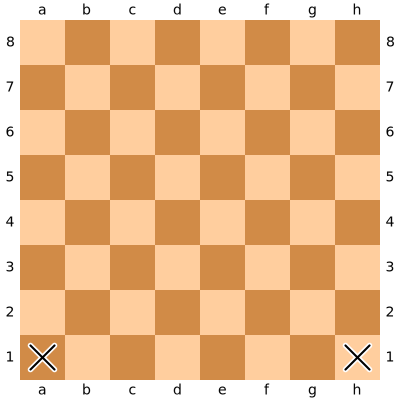

In [28]:
board = chess.Board()

board.pieces(chess.ROOK, True)

In [29]:
list(board.pieces(chess.ROOK, True))

[0, 7]

In [30]:
len(board.pieces(chess.ROOK, True))

2

In [31]:
def staticAnalysis(board, move, my_color):
    score = 0
    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # To actually make the move:
    board.push(move)
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, my_color)) * value
        score -= len(board.pieces(piece, not my_color)) * value
        # can also check things about the pieces position here
    return score

In [33]:
play_game(player1, random_player)

draw: claim


(None, 'draw: claim', Board('6R1/8/2p2p2/7k/8/6P1/PPPPPP2/RNBQK3 w Q - 11 29'))

In [34]:
def staticAnalysis(board, move, my_color):
    score = random.random()
    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # To actually make the move:
    board.push(move)
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, my_color)) * value
        score -= len(board.pieces(piece, not my_color)) * value
        # can also check things about the pieces position here
    return score

In [35]:
play_game(player1, random_player)

draw: stalemate


(None,
 'draw: stalemate',
 Board('6B1/6R1/8/5P1k/2PP4/P2P2KP/8/RNB5 b - - 4 53'))

In [36]:
def staticAnalysis(board, move, my_color):
    score = random.random()
    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # To actually make the move:
    board.push(move)
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, my_color)) * value
        score -= len(board.pieces(piece, not my_color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score

In [37]:
play_game(player1, random_player)

checkmate: White wins!


(True,
 'checkmate: White wins!',
 Board('rnbqkbnr/ppppp1p1/5pQ1/8/2P4p/6P1/PP1PPP1P/RNB1KBNR b KQkq - 1 4'))

In [4]:
import pandas as pd

In [6]:
pd.read_csv('games.csv').head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
